<a href="https://colab.research.google.com/github/asheta66/CNN/blob/main/Breast_Diagnosis_Model_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# !pip install tensorflow-addons

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import UnidentifiedImageError
import itertools  # Import itertools

# Define possible resolution options and corresponding folder names
resolutionOptions = {
    '32x32': (32, 32),
    '56x56': (56, 56),
    '128x128': (128, 128),
    '256x256': (256, 256),
    '512x512': (512, 512)
}

# Ask the user to select a resolution
print("Select the resolution:")
for i, (res_name, res_size) in enumerate(resolutionOptions.items(), 1):
    print(f"{i}. {res_name}")

selectionIndex = int(input("Enter the number corresponding to your choice: ")) - 1
if selectionIndex < 0 or selectionIndex >= len(resolutionOptions):
    raise ValueError("Invalid selection. Exiting.")

# Construct the data directory path and resolution based on the selected resolution
selectedResolutionName = list(resolutionOptions.keys())[selectionIndex]
selectedResolutionSize = resolutionOptions[selectedResolutionName]
data_dir = os.path.join('/content/drive/My Drive/data2', selectedResolutionName)

# Display the selected directory path and resolution
print(f"Selected data directory: {data_dir}")
print(f"Selected resolution: {selectedResolutionSize}")

# Check if the data directory exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Directory '{data_dir}' does not exist.")

# Get the list of class names (subfolders)
classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]

# Define the number of images to pick from each class
num_images_per_class = 266

# Function to build and compile the CNN model
def build_compile_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', precision, recall, f1_score])
    return model

# Custom metrics
def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

def plot_confusion_matrices(cm_train, cm_test, classes, train_title, test_title, filename, font_size=10):
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))

    # Training confusion matrix
    ax[0].imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues)
    ax[0].set_title(train_title, fontsize=font_size)
    tick_marks = np.arange(len(classes))
    ax[0].set_xticks(tick_marks)
    ax[0].set_yticks(tick_marks)
    ax[0].set_xticklabels(classes, rotation=45, fontsize=font_size)
    ax[0].set_yticklabels(classes, fontsize=font_size)
    fmt = 'd'
    thresh = cm_train.max() / 2.
    for i, j in itertools.product(range(cm_train.shape[0]), range(cm_train.shape[1])):
        ax[0].text(j, i, format(cm_train[i, j], fmt),
                   horizontalalignment="center",
                   color="white" if cm_train[i, j] > thresh else "black",
                   fontsize=font_size)
    ax[0].set_ylabel('True label', fontsize=font_size)
    ax[0].set_xlabel('Predicted label', fontsize=font_size)
    ax[0].grid(False)

    # Testing confusion matrix
    ax[1].imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
    ax[1].set_title(test_title, fontsize=font_size)
    ax[1].set_xticks(tick_marks)
    ax[1].set_yticks(tick_marks)
    ax[1].set_xticklabels(classes, rotation=45, fontsize=font_size)
    ax[1].set_yticklabels(classes, fontsize=font_size)
    fmt = 'd'
    thresh = cm_test.max() / 2.
    for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
        ax[1].text(j, i, format(cm_test[i, j], fmt),
                   horizontalalignment="center",
                   color="white" if cm_test[i, j] > thresh else "black",
                   fontsize=font_size)
    ax[1].set_ylabel('True label', fontsize=font_size)
    ax[1].set_xlabel('Predicted label', fontsize=font_size)
    ax[1].grid(False)

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Function to draw subplots for each class at different resolutions
def plot_class_resolutions(data_dir, classes, resolutions):
    num_classes = len(classes)
    num_resolutions = len(resolutions)

    if num_classes > 1 and num_resolutions > 1:
        fig, axes = plt.subplots(num_classes, num_resolutions, figsize=(12,12))
    else:
        fig, axes = plt.subplots(num_classes, num_resolutions, figsize=(12,6) if num_resolutions > 1 else (6,12))

    # Iterate over each class
    for class_idx, cls in enumerate(classes):
        cls_dir = os.path.join(data_dir, cls)
        img_files = os.listdir(cls_dir)
        random_img_file = random.choice(img_files)  # Randomly select an image from the class

        # Iterate over each resolution
        for res_idx, resolution in enumerate(resolutions):
            img = load_resized_image(data_dir, cls, random_img_file, resolution)

            # Plot the image in the corresponding subplot
            if num_classes > 1 and num_resolutions > 1:
                ax = axes[class_idx, res_idx]
            else:
                ax = axes[0, res_idx] if num_classes == 1 else axes[class_idx, 0]

            ax.imshow(img)
            ax.axis('off')  # Hide axes ticks
            if class_idx == 0:
                ax.set_title(f'{resolution[0]}x{resolution[1]}', fontsize=11)  # Set resolution as title for the top row
            if res_idx == 0:
                ax.set_ylabel(cls, fontsize=11)  # Set class name as y-label for the first column

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.savefig('class_resolutions.png')
    plt.show()

# Function to resize and load a single image
def load_resized_image(directory, cls, img_file, size):
    img_path = os.path.join(directory, cls, img_file)
    img = Image.open(img_path)
    img = img.resize(size)
    return img

# Lists to store results
histories = []
confusion_matrices_train = []
confusion_matrices_test = []
classification_reports_train = []
classification_reports_test = []

# Prepare data
X, y = [], []
label_map = {cls: idx for idx, cls in enumerate(classes)}

for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    img_files = os.listdir(cls_dir)

    # Ensure the number of images does not exceed the number to pick
    if len(img_files) > num_images_per_class:
        img_files = random.sample(img_files, num_images_per_class)

    for img_file in img_files:
        img_path = os.path.join(cls_dir, img_file)
        img = load_img(img_path)
        img_array = img_to_array(img)
        X.append(img_array)
        y.append(label_map[cls])

X = np.array(X).astype('float32') / 255.0
y = np.array(y).astype('int')

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=23)

# Use the selected resolution
print(f"Running model with resolution {selectedResolutionSize}...")

# Resize images
X_train_resized = np.array([np.array(load_resized_image(data_dir, cls, img_file, selectedResolutionSize)) for cls in classes for img_file in os.listdir(os.path.join(data_dir, cls)) if os.path.isfile(os.path.join(data_dir, cls, img_file))])
X_test_resized = np.array([np.array(load_resized_image(data_dir, cls, img_file, selectedResolutionSize)) for cls in classes for img_file in os.listdir(os.path.join(data_dir, cls)) if os.path.isfile(os.path.join(data_dir, cls, img_file))])

# Filter out only the resized images corresponding to the train and test splits
def filter_resized_images(image_paths, X_resized):
    return np.array([X_resized[i] for i in range(len(image_paths)) if image_paths[i] in image_paths])

X_train_resized = filter_resized_images(X_train, X_train_resized)
X_test_resized = filter_resized_images(X_test, X_test_resized)

input_shape = (selectedResolutionSize[0], selectedResolutionSize[1], 3)
num_classes = len(classes)

model = build_compile_model(input_shape, num_classes)
history = model.fit(X_train_resized, y_train, epochs=10, validation_split=0.2)

# Predict and evaluate
y_train_pred = np.argmax(model.predict(X_train_resized), axis=1)
y_test_pred = np.argmax(model.predict(X_test_resized), axis=1)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

report_train = classification_report(y_train, y_train_pred, target_names=classes)
report_test = classification_report(y_test, y_test_pred, target_names=classes)

# Store results
histories.append(history)
confusion_matrices_train.append(cm_train)
confusion_matrices_test.append(cm_test)
classification_reports_train.append(report_train)
classification_reports_test.append(report_test)

# Plot confusion matrices
plot_confusion_matrices(cm_train, cm_test, classes,
                        train_title=f'Confusion Matrix (Train) - {selectedResolutionSize[0]}x{selectedResolutionSize[1]}',
                        test_title=f'Confusion Matrix (Test) - {selectedResolutionSize[0]}x{selectedResolutionSize[1]}',
                        filename=f'confusion_matrix_{selectedResolutionSize[0]}x{selectedResolutionSize[1]}.png')


**Output Model Results**

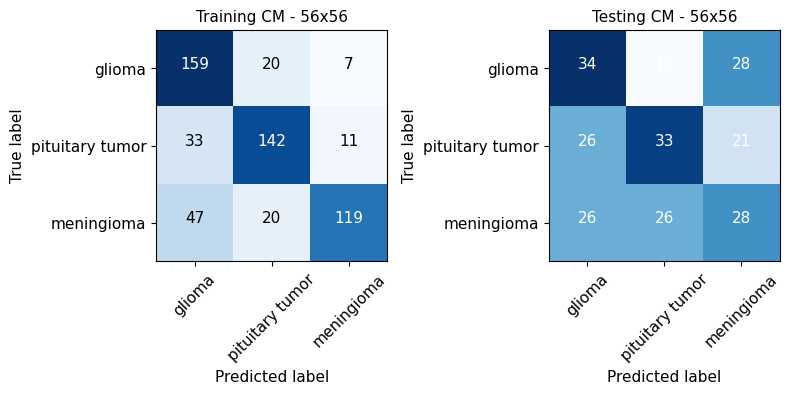

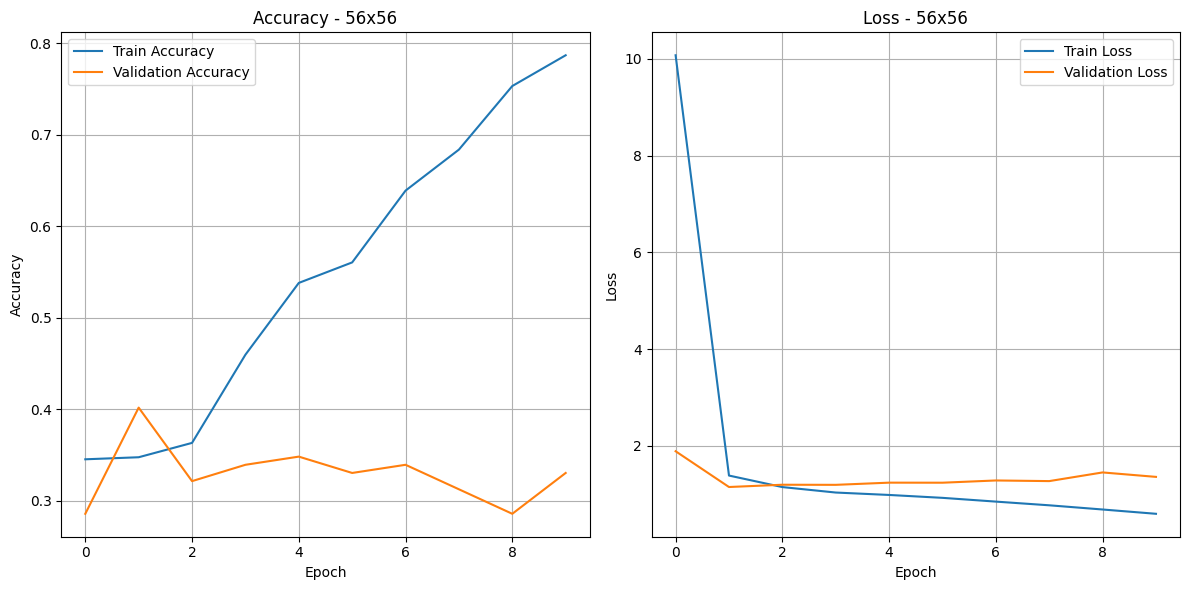

In [22]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Define a resolution string for filenames
resolution_str = f'{selectedResolutionSize[0]}x{selectedResolutionSize[1]}'

# Save the confusion matrices as PNG
plot_confusion_matrices(cm_train, cm_test, classes,
                        f'Training CM - {resolution_str}',
                        f'Testing CM - {resolution_str}',
                        f'confusion_matrices_{resolution_str}.png',
                        font_size=11)

# Save the CNN architecture as a PNG figure
plot_model(model, to_file=f'model_architecture_{resolution_str}.png', show_shapes=True, show_layer_names=True)

# Plot convergence curves (accuracy and loss in one figure as subplots) and save as PNG
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.set_title(f'Accuracy - {resolution_str}')
ax1.grid()

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.set_title(f'Loss - {resolution_str}')
ax2.grid()

plt.tight_layout()
plt.savefig(f'convergence_curve_{resolution_str}.png')
plt.show()


In [21]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize a list to store metrics for saving
metrics = []

# After training and predictions
train_predictions = np.argmax(model.predict(X_train), axis=1)
test_predictions = np.argmax(model.predict(X_test), axis=1)

# Compute metrics
accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions, average='weighted')
recall = recall_score(y_test, test_predictions, average='weighted')
f1 = f1_score(y_test, test_predictions, average='weighted')

# Store metrics in the list
metrics.append({
    'Resolution': f'{resolution[0]}x{resolution[1]}',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

# Create a DataFrame from the metrics list
metrics_df = pd.DataFrame(metrics)

# Define filename with resolution
excel_filename = f'performance_metrics_{resolution[0]}x{resolution[1]}.xlsx'

# Save the DataFrame to an Excel file
metrics_df.to_excel(excel_filename, index=False, sheet_name='Performance Metrics')

print(f"Metrics saved to {excel_filename}")


8/8 [==============================] - 0s 20ms/step
Metrics saved to performance_metrics_32x32.xlsx


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
